# Time Series Forcasting


- TODO Mike this is too long, can't get through it all. Cut ARMA etc
- TODO arima has poor results
- TODO too many blocks of text
- TODO wind daily is a poor choice for autoregressive, since it's not
- TODO can't install the auto arima one
- TODO compare prophet to actual future data

In time series forcasting (TSF) the goal is to predict the future values using the behaviour of data in the past. We can use some of the tehniques we learned about in the last notebook. For instance, Holt-Winters methods can be used for forcasting as well as analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv(
    "../../data/processed/Generated/Customers.csv", parse_dates=True, index_col="Month"
)

In [3]:
df

,Customers
Month,
1994-01-01,412
1994-02-01,406
1994-03-01,456
1994-04-01,440
1994-05-01,422
...,...
2005-08-01,2070
2005-09-01,1738
2005-10-01,1578


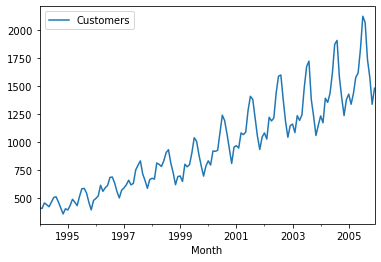

In [4]:
df.plot()

In forcasting we try to predict the next step, therefore it is essential that we specify the frequency of data so the model knows what we mean by next step. Pandas data frames have frequency property, which by default is not set. So we need to set the frequency manually. <br>
We can find information about the frequency in index of data frame.

In [5]:
df.index

DatetimeIndex(['1994-01-01', '1994-02-01', '1994-03-01', '1994-04-01',
               '1994-05-01', '1994-06-01', '1994-07-01', '1994-08-01',
               '1994-09-01', '1994-10-01',
               ...
               '2005-03-01', '2005-04-01', '2005-05-01', '2005-06-01',
               '2005-07-01', '2005-08-01', '2005-09-01', '2005-10-01',
               '2005-11-01', '2005-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

You can see at the bottom `freq` is set to `None`. We need to specify the the data is monthly and the dates are start of the month. So we use `freq = "MS"`.

In [6]:
df.index.freq = "MS"

__Note:__ Most of the algorithms have ways of infering the frequency if it is not set. But it is always safer to set it ourselves rather than leave it for the algorithms to figure out.

To measure whether we are doing well in our prediction or not, commonly we split the data into two parts, one for training the model and the other for evaluating the forcasting quality. The part that is used for taining is called training set and for time series it usually is the data from the beginning up to a certain point in time. The part that is used for evaluation is may be called validation set, test set, or evaluation set. The validation set comes right after the training set, because we use the training set to understand the behaviour of data and then we want to know what is going to happen right after that.<br>
Let's split our data into training and validation set. Let's split in a way so that last 24 months are in validation set and the rest in training set.

In [7]:
n_months = 24
df_train = df.iloc[:-n_months]
df_valid = df.iloc[-n_months:]

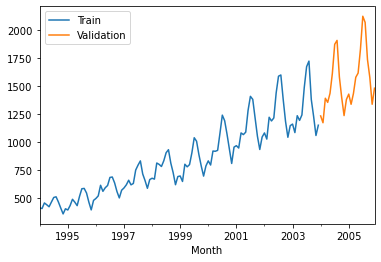

In [8]:
ax = df_train['Customers'].plot(legend=True, label="Train")
df_valid['Customers'].plot(ax=ax, legend=True, label="Validation")

In [9]:
model = ExponentialSmoothing(
    df_train["Customers"], trend="mul", seasonal="mul", seasonal_periods=12
)
trained_model = model.fit(
    smoothing_level=0.3, smoothing_slope=0.3, smoothing_seasonal=0.3
)

In [10]:
forecast = trained_model.forecast(24)

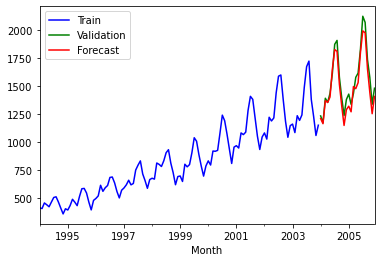

In [11]:
ax = df_train["Customers"].plot(legend=True, label="Train", color="blue")
df_valid["Customers"].plot(ax=ax, legend=True, label="Validation", color="green")
forecast.plot(ax=ax, legend=True, label="Forecast", color="red")

Let's have a closer look.

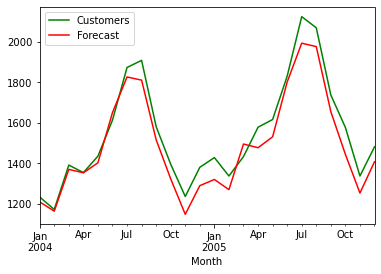

In [12]:
ax = df_valid.plot(legend=True, label="Validation", color="green")
forecast.plot(ax=ax, legend=True, label="Forecast", color="red")

It's pretty close. But how close? We need to put a value on the goodness of the result. To do this, we can use metrics. There are various metrics which can be used here, such as root of mean squared error (RMSE), mean squered error (MSE), mean absolute error (MAE), $R^2$, and many more. Sometimes for a certain application you might need to use particular metric.<br>
There is a package called Scikit Learn which is a common package for machine learning and data science. This package contains many useful functions and algorithms. One of them is metrics submodule where various types of metrics are available. 

In [13]:
from sklearn.metrics import mean_absolute_error as mae

Most of Scikit Learn metric functions need the same inputs. We need to pass in the actual values, and the predicted values.<br>


In [14]:
??mae

In [15]:
mae(y_true=df_valid, y_pred=forecast)

68.11273730073114

This value shows on average how much our forecast was off from the reality. <br>


__Change the value of alpha, beta, and gamma and see whether it improves the model.__

In [16]:
model.fit??

142.1438119514869

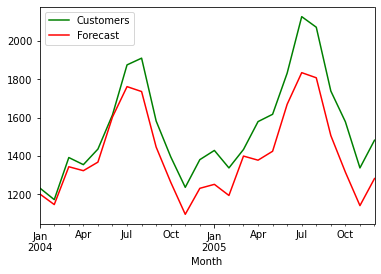

In [17]:
# TODO, mike, read up:
# - why isn't this improving it, are we stopping it from auto finding params
alpha = 0.4
beta = 0.3
gamma = 0.3
model = ExponentialSmoothing(
    df_train["Customers"], trend="mul", seasonal="mul", seasonal_periods=12
)
trained_model = model.fit(
    smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma
)
forecast = trained_model.forecast(24)
ax = df_valid.plot(legend=True, label="Validation", color="green")
forecast.plot(ax=ax, legend=True, label="Forecast", color="red")
mae(y_true=df_valid, y_pred=forecast)

## Stationarity

A time series is considered stationary when its properties (mean and standard deviation) does not change with time. Therefore, any time series with trend or seasonality is not stationary. An example of stationary data is white noise:

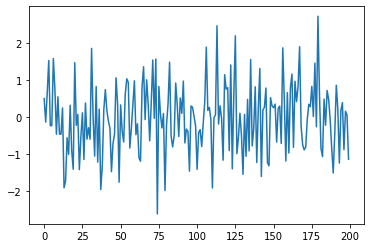

In [18]:
np.random.seed(42)
y = np.random.randn(200)
plt.plot(y)

While it is easy to tell if a time series is not stationary when there is a clear trend, in some cases it might be pretty difficult to decide whether a time series is stationary or not. Therefore, we use statistical tests to make a decision.


#### Augmented Dickey-Fuller test

TODO mike understand or delete

[Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) (ADF) is a statistical test for stationarity. We are not going to discuss the statistical details of this test, but what matters to us is the result. The null hpothesis of ADF is that there is a [unit root](https://en.wikipedia.org/wiki/Unit_root) in the time series. The alternative hypothesis is that the series is stationary. To use the test we are looking for the p-value. If p-value is lower than a hreshold (commonly 0.05), it means the null hypothesis is rejected and therefore the time series is stationary.<br>
Let's test it on our data.

In [19]:
from statsmodels.tsa.stattools import adfuller

In [20]:
adfuller(df["Customers"])

(0.8501837118218679,
 0.9924045241642753,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 1311.795141838217)

The function returns many values, but the one that we are interested in is p-value, which the second value. If it is less than 0.05, it means time series is stationary. In this case it is far from 0.05 and that is what we expected as the data has clear trend.<br>
Now let's turn it into a function that only return the p-value and run the test on white noise.

In [21]:
def adf(data):
    res = adfuller(data)
    return res[1]

In [22]:
adf(y)

2.543125112212854e-27

The value is very small, which suggests we can reject the null hypothesis and therefore the series is stationary.

What if we remove trend and seasonality from the data using STL method?

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

''

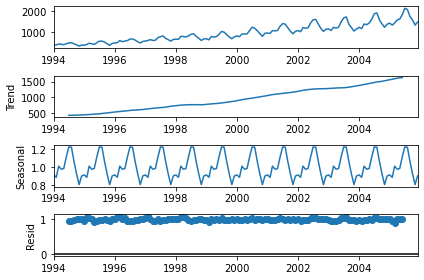

In [24]:
res = seasonal_decompose(df, model="mul")
res.plot()
''

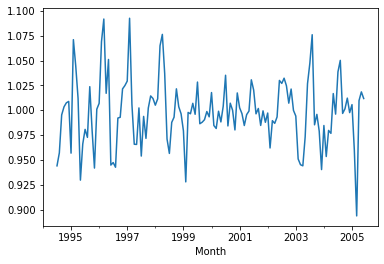

In [25]:
res.resid.plot()

If we remove the seasonal and trend component what is left is the residuals.<br>
The residuals might have `NaN` in it. If so, we need to remove them before performing the test.

In [26]:
adf(res.resid.dropna())

8.875932753158083e-11

The residual is stationary.

__Why is it important if a time series is stationary or not?__<br>
We know that in a stationary time series the characteristics will remain constant. This makes it easier to predict their future behaviour as we expect them to behave similarly. But when the series is not stationary we don't know how it is going to behave in the future. In reality, most of the time series we are going to work with are not stationary. But using various techniques we might be able to transform them into a stationary time series. This is exactly what we just did. We use STL to remove the trend and seasonality to get a stationary time series.

Another technique to make a time series stationary is differencing. Differencing means that we calculate the difference between two consecutive points in time. Then we use the differences for forcasting.<br>
Let's see how differencing will affect our data. Pandas has a builtin method for differencing (`.diff()`):

In [27]:
df.diff()

,Customers
Month,
1994-01-01,NaN
1994-02-01,-6.0
1994-03-01,50.0
1994-04-01,-16.0
1994-05-01,-18.0
...,...
2005-08-01,-55.0
2005-09-01,-332.0
2005-10-01,-160.0


We need to get rid of `NaN` so we can run the test.

In [28]:
adf(df.diff().dropna()["Customers"])

0.04819711316088397

As we can see p-value is just below 0.05 threshold, which means differencing helped to convert data into stationary time series. <br>
In some cases you might need to perform differencing multiple times to reach stationary results.

In [29]:
adf(df.diff(2).dropna()["Customers"])

0.03402856442850812

## Autocorrelation

Another characteristics of a time series is autocorrelation. Autocorrelation is simply the correlation between the points in the time series and the points before them (sometimes called lagged values).

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
# TODO mike, what is the shaded area?

''

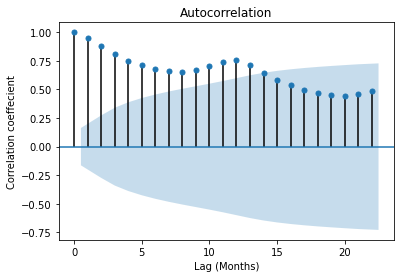

In [31]:
plot_acf(df)
plt.xlabel('Lag (Months)')
plt.ylabel('Correlation coeffecient')
''

The points closer together in time have higher correlation compared to the points further apart. This is an expected behaviour. However, how quickly does the correlation decreases is important.

## Autoregressive models (AR)
An [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model), is a time series model which assumes a linear relationship between each point in time and its past $p$ points.

$$y_t=c+\sum_{i=1}^{p}\phi_iy_{t-i}$$
For instance a first order AR (also shown as AR(1)) can be written as:<br>
$$y_t=c+\phi_1 y_{t-1}$$
This model can be found in statsmodels in ar_model submodule.

In [32]:
# This is to avoid some warning messages from statsmodels
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [33]:
from statsmodels.tsa.ar_model import AR, ARResults

Let's try an AR model on our data. First we need to split the data into a training and validation set.

We use a datasets which contains information about power consumption in a building and weather data, but the one we are going to use is wind speed.

In [84]:
df = pd.read_csv(
    "../../data/processed/Generated/energy_weather.csv",
    parse_dates=True,
    index_col="date",
)
df = df[["Windspeed"]]
df.head()

,Windspeed
date,
2012-01-07 17:00:00,7.2
2012-01-07 17:10:00,6.9
2012-01-07 17:20:00,6.8
2012-01-07 17:30:00,6.7
2012-01-07 17:40:00,5.5


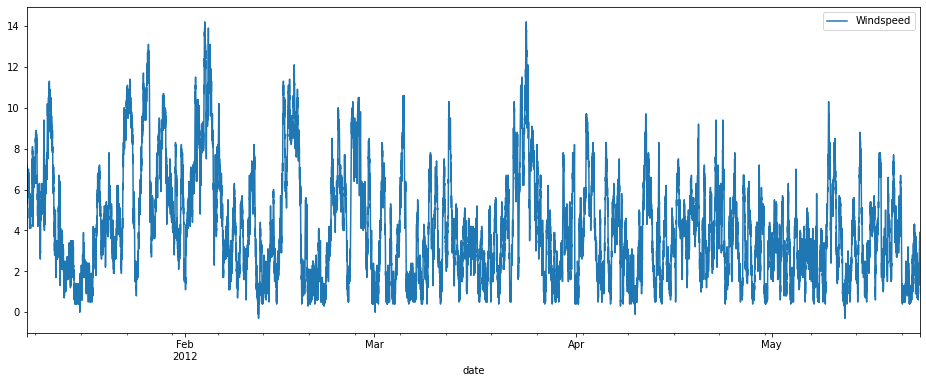

In [85]:
df.plot(figsize=(16, 6))

Resample the data to get average daily wind speed.

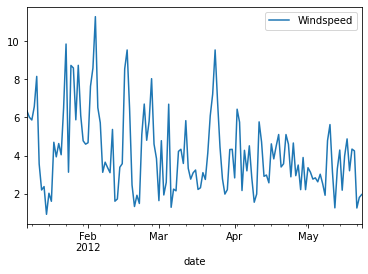

In [36]:
df = df.resample("D").mean()
df.plot()

Now let's repeat some of the tests on this dataset.

In [37]:
adf(df["Windspeed"])

8.338222839538583e-09

''

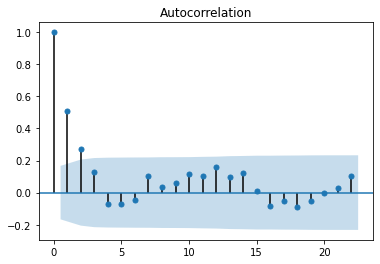

In [38]:
plot_acf(df)
''

Before training a model we split thedata into training and validation sets.

In [39]:
df_train = df.iloc[:-30]
df_valid = df.iloc[-30:]

Then we create an instance of AR model using the training data.

In [40]:
model = AR(df_train)

Then we train the model specifying the order of AR. Let's start by trying `1`.

In [41]:
trained_model = model.fit(maxlag=1)

Now the model is trained. We can view model's values:

In [42]:
trained_model.params

const           2.165026
L1.Windspeed    0.510017
dtype: float64

More importantly, we can forecast using the trained model. To do that, we need to at which time-step in the training data the model should stat and at which time-step it should stop. Since we want the predictions for validation data, we need to start right after last index of training data, so we use starting index as `len(df_train)` (Note that indexing starts from `0`).<br> Likewise, the last index would be sum of the lengths of training and validation sets.

In [43]:
start = len(df_train)
end = len(df_train) + len(df_valid) - 1
forecast = trained_model.predict(start, end)

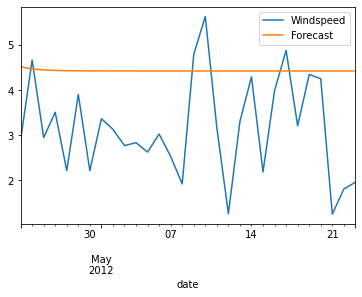

In [44]:
ax = df_valid.plot(legend=True, label="Actual")
forecast.plot(ax=ax, legend=True, label="Forecast")

That's not so good! Let's calculate mean absolute error:

In [45]:
mae(df_valid, forecast)

1.4133847422855654

Now let's try larger models by increasing order of AR. 

1.3917564877239896

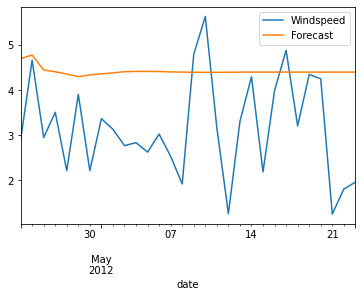

In [46]:
model = AR(df_train)
model = model.fit(maxlag=4)
start = len(df_train)
end = len(df_train) + len(df_valid) - 1
forecast = model.predict(start, end)
ax = df_valid.plot(legend=True, label="Actual")
forecast.plot(ax=ax, legend=True, label="Forecast")
mae(df_valid, forecast)

Try a few other values yourself and see if you get a better result.

1.4347592680315862

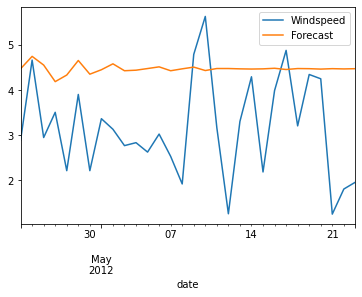

In [47]:
model = AR(df_train)
model = model.fit(maxlag=10)
start = len(df_train)
end = len(df_train) + len(df_valid) - 1
forecast = model.predict(start, end)
ax = df_valid.plot(legend=True, label="Actual")
forecast.plot(ax=ax, legend=True, label="Forecast")
mae(df_valid, forecast)

## ARMA and ARIMA

TODO (mike) this equation doens't match the params

An autoregressive moving average (ARMA) model is model made of two components, a autoregressive model (AR) and a [moving average model](https://en.wikipedia.org/wiki/Moving-average_model) (MA).

$$y_t = c + \varepsilon_t +  \sum_{i=1}^p \varphi_i y_{t-i} + \sum_{i=1}^q \theta_i \varepsilon_{t-i}$$
There is also a generalisation of ARMA, which is called autoregressive integrated moving average (ARIMA). ARIMA is simlar to ARMA except is has the integrated term which is referring to ARIMA'a ability to take a difference of the data as well. As we dicussed taking a difference of data can turn it into a stationary time series. ARIMA has the ability to do it automatically. When training an ARIMA model we need to specify three values:
1. order of AR ($p$)
2. order of differencing ($d$)
3. order of moving average ($q$)

When $d = 0$, ARIMA will turn into ARMA model. Statsmodels has an implementation of ARIMA which we can use for training ARMA and ARIMA models.

In [48]:
from statsmodels.tsa.arima_model import ARIMA

1.4519427790252049

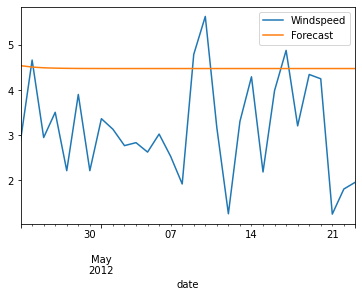

In [49]:
df_train = df.iloc[:-30]
df_valid = df.iloc[-30:]
p = 1
d = 0
q = 1
model = ARIMA(df_train, (p, d, q))
model = model.fit()
start = len(df_train)
end = len(df_train) + len(df_valid) - 1
forecast = model.predict(start, end)
ax = df_valid.plot(legend=True, label="Actual")
forecast.plot(ax=ax, legend=True, label="Forecast")
mae(df_valid, forecast)

1.4454987981897927

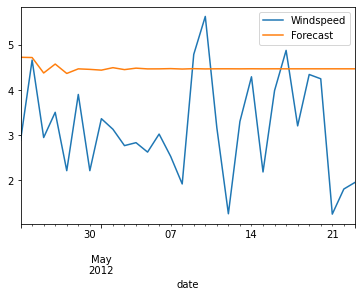

In [50]:
p = 4
d = 0
q = 1
model = ARIMA(df_train, (p, d, q))
model = model.fit()
start = len(df_train)
end = len(df_train) + len(df_valid) - 1
forecast = model.predict(start, end)
ax = df_valid.plot(legend=True, label="Actual")
forecast.plot(ax=ax, legend=True, label="Forecast")
mae(df_valid, forecast)

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              Windspeed   No. Observations:                  108
Model:                     ARMA(4, 1)   Log Likelihood                -217.238
Method:                       css-mle   S.D. of innovations              1.802
Date:                Wed, 16 Sep 2020   AIC                            448.477
Time:                        07:01:39   BIC                            467.252
Sample:                    01-07-2012   HQIC                           456.089
                         - 04-23-2012                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.4663      0.314     14.245      0.000       3.852       5.081
ar.L1.Windspeed    -0.2140      0.133     -1.606      0.108      -0.475       0.047
ar.L2.Windspeed     0.3979      0.107      3.731      0.000       0.189       0.607
ar.L3.Windspeed     0.0662      0.096      0.692      0.489      -0.121       0.253
ar.L4.Windspeed    -0.2341      0.097     -2.423      0.015      -0.423      -0.045
ma.L1.Windspeed     0.7833      0.108      7.246      0.000       0.571       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1438           -0.6870j            1.3342           -0.4139
AR.2           -1.1438           +0.6870j            1.3342            0.4139
AR.3            1.2851           -0.8650j            1.5491           -0.0943
AR.4            1.2851           +0.8650j            1.5491            0.0943
MA.1           -1.2767           +0.0000j            1.2767            0.5000
-----------------------------------------------------------------------------
"""

While we can easily get the forecasted values from an ARMA model, when working with ARIMA models we need to add a few extra steps. To get the forecasted values of ARMA model we used `.predict()` in code above. But this method does not inverse the differencing operation (which is part of ARIMA). However, there is another method called `.forecast()` which does inversion. <br>
There is another difference between `predict` and `forecast`. `predict` uses the points that we have and predicts a single time-step ahead. So when we ask predict to do more than one step, at each step it uses the actual data. `forecast` uses the model trained on the training set and produces new values.

Here we recreate the predict function for ARIMA by training the model on the entire history of data, and then forcast one step ahead and then retrain the model using the entire data up to that point again.

In [52]:
from tqdm import tqdm

100%|██████████| 30/30 [00:09<00:00,  3.33it/s]


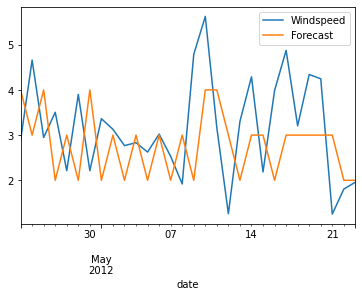

In [53]:
p = 3
d = 1
q = 2

df_train = df.iloc[:-30]
df_valid = df.iloc[-30:]
df_valid = df_valid.assign(Forecast=0)
history = [x for x in df_train["Windspeed"]]

for t in tqdm(range(len(df_valid))):
    model = ARIMA(history, order=(p, d, q))
    trained_model = model.fit(disp=0)
    output = trained_model.forecast()
    pred = output[0]
    df_valid["Forecast"][t] = pred
    history.append(df_valid.values[t, 0])
df_valid.plot()

Finding the right parameters for ARIMA is critical. You can do it manually by trying various values and see which one works the best, or use `auto_arima` function from `pmdarima` which does the same thing for you. We arn't going to cover it here, but the parameters it suggests are: (2, 1, 3)

TODO mike

In [86]:
# TODO mike are we allowed to use this??
from pmdarima import auto_arima

In [ ]:
res = auto_arima(df, suppress_warnings=True, error_action="ignore")

We can see the order of the best ARIMA model.

In [91]:
res.get_params()#["order"]

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 3),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

# Seasonal ARIMA (SARIMA)
As the name suggest this model is the same as ARIMA but adjusted to deal with seasonality. To train a SARIMA we need to sets of parameters. The first set is the ARIMA parameters ($p$,$d$,$q$), and the second set is for seasonality ($P$,$D$,$Q$,$m$). $P$,$D$, and $Q$ are orders of autoregressive, differencing, moving average component of seasonality and $m$ is the length of seasonality.<br>
To train a SARIMA model we use a submodule of statsmodels called `SARIMAX` (we will get to what the "X" means shortly).


In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Let's use a set of data with seasonality.

In [59]:
df = pd.read_csv(
    "../../data/processed/Generated/energy_weather.csv",
    parse_dates=True,
    index_col="date",
)
df = df[["Windspeed"]]
df.head()

,Windspeed
date,
2012-01-07 17:00:00,7.2
2012-01-07 17:10:00,6.9
2012-01-07 17:20:00,6.8
2012-01-07 17:30:00,6.7
2012-01-07 17:40:00,5.5


In [60]:
p = 2
d = 1
q = 2

P = 1
D = 1
Q = 1
m = 12

df_train = df.iloc[:-24]
df_valid = df.iloc[-24:]

model = SARIMAX(df_train, order=(p, d, q), seasonal_order=(P, D, Q, m))
trained_model = model.fit()

KeyboardInterrupt: 

In [ ]:
trained_model.summary()

Forecast using the trained model.

In [ ]:
start = len(df_train)
end = len(df_train) + len(df_valid) - 1
pred = trained_model.predict(start=start, end=end, dynamic=False, typ="levels")

In [ ]:
plt.plot(df_valid, label="Actual")
plt.plot(pred, label="Forecase")
plt.legend()

We can use auto_arima to find the best parameters for SARIMA as well. We just need to specify the season length ($m$) and it will search for seasonal parameters as well. Note that since there more parameters to find the process might take longer.

In [ ]:
trained_model = auto_arima(df, suppress_warnings=True, error_action="ignore", m=12)
trained_model.summary()

The summary shows the best values for SARIMA model. You can also see the values used in the model (in AR, MA, etc) and their statistics.

## SARIMAX
SARIMAX is a SARIMA model with exogenous regressors. An exogenous factor is an external factor affecting the time series. This allows the model to make predictions not only based on the sequence of data but also external factors that might affect the time series.

The data set below has the power consumption in a house as well as temperature outside. Let's see if including the temperature can improve energy usage forcasting.

In [ ]:
df = pd.read_csv(
    "../../data/processed/Generated/energy_weather.csv",
    parse_dates=True,
    index_col="date",
)
df = df[["Power", "T_out"]]
df.head()

In [ ]:
df = df.resample("2H").agg({"Power": np.sum, "T_out": np.mean})

In [ ]:
df.plot(y="Power")

In [ ]:
df_train = df.iloc[:-240]
df_valid = df.iloc[-240:]

In [ ]:
model = SARIMAX(
    df_train["Power"], df_train["T_out"], order=(2, 1, 2), seasonal_order=(2, 0, 2, 12)
)

In [ ]:
res = model.fit()

In [ ]:
res.summary()

In [ ]:
start = len(df_train)
end = len(df_train) + len(df_valid) - 1
pred = res.predict(start=start, end=end, dynamic=False, exog=df_valid[["T_out"]])

In [ ]:
plt.plot(df_valid["Power"].values, label="Actual")
plt.plot(pred.values, label="Forecast")
plt.legend()

In [ ]:
mae(df_valid["Power"], pred)

Let's compare it to a scenario where we don't use an exogenous factor.

In [ ]:
model = SARIMAX(df_train["Power"], order=(2, 1, 2), seasonal_order=(2, 0, 2, 12))
res = model.fit()
start = len(df_train)
end = len(df_train) + len(df_valid) - 1
pred = res.predict(start=start, end=end, dynamic=False)
mae(df_valid["Power"], pred)

You could also run `auto_arima` to find the best parameters for the model.

# Prophet
Prophet is a time series analysis and forecasting package developed by Facebook. Prophet allows you to train forscasting models with minimal need to adjust the models patameters. Prophet is particularly useful when you are dealing with data that has multiple levels of seasonality.<br>
Let's start by importing the library. The name of the package is `fbprophet`.

In [61]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


Next, we will load a subset of London Smart meters dataset. This dataset shows electricity consumption of 5,567 houses in London. We will only use the data for a single block. The data shows daily consumption of each house and various statistics regarding their daily consumption.

In [62]:
# TODO mike what is LCLid

In [89]:
block0 = pd.read_csv("../../data/processed/smartmeter/block_0.csv")
block0

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000002,2012-10-12,0.1385,0.154304,0.886,46,0.196034,7.098,0.000
1,MAC000002,2012-10-13,0.1800,0.230979,0.933,48,0.192329,11.087,0.076
2,MAC000002,2012-10-14,0.1580,0.275479,1.085,48,0.274647,13.223,0.070
3,MAC000002,2012-10-15,0.1310,0.213688,1.164,48,0.224483,10.257,0.070
4,MAC000002,2012-10-16,0.1450,0.203521,0.991,48,0.184115,9.769,0.087
...,...,...,...,...,...,...,...,...,...
25569,MAC005492,2014-02-24,0.1690,0.175042,0.378,48,0.073174,8.402,0.079
25570,MAC005492,2014-02-25,0.1550,0.160792,0.545,48,0.082118,7.718,0.079
25571,MAC005492,2014-02-26,0.1490,0.178542,0.687,48,0.120820,8.570,0.079
25572,MAC005492,2014-02-27,0.1140,0.146167,0.478,48,0.082616,7.016,0.079


In [65]:
block0["day"]

0        2012-10-12
1        2012-10-13
2        2012-10-14
3        2012-10-15
4        2012-10-16
            ...    
25569    2014-02-24
25570    2014-02-25
25571    2014-02-26
25572    2014-02-27
25573    2014-02-28
Name: day, Length: 25574, dtype: object

Now we need to make sure dates are saved in datetime format.

In [66]:
block0["day"] = block0["day"].astype("datetime64")
block0["day"]

0       2012-10-12
1       2012-10-13
2       2012-10-14
3       2012-10-15
4       2012-10-16
           ...    
25569   2014-02-24
25570   2014-02-25
25571   2014-02-26
25572   2014-02-27
25573   2014-02-28
Name: day, Length: 25574, dtype: datetime64[ns]

We plan to forcast average daily electricity consumption of a house. So we only need `energy_sum` which is total energy consumed in a day and also the dates and ids. We group them by date and take an average to get average daily consumption.

In [67]:
df = block0[["LCLid", "day", "energy_sum"]].groupby(by="day").mean()

In [68]:
df.head()

,energy_sum
day,
2011-12-03,9.007
2011-12-04,20.763
2011-12-05,6.020
2011-12-06,13.322
2011-12-07,9.062


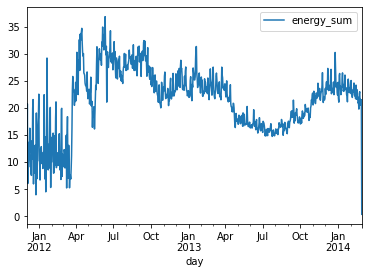

In [69]:
df.plot()

Prophet need the input data to be in a very specific format. The data needs to have a column containing daily dates called `"ds"`, and a column containing values named `"y"`. So we create a new data frame and use the required column names.

In [70]:
df = pd.DataFrame({"ds": df.index, "y": df["energy_sum"]}).reset_index(drop=True)
df

,ds,y
0,2011-12-03,9.007000
1,2011-12-04,20.763000
2,2011-12-05,6.020000
3,2011-12-06,13.322000
4,2011-12-07,9.062000
...,...,...
814,2014-02-24,20.788405
815,2014-02-25,21.585762
816,2014-02-26,20.497476
817,2014-02-27,21.492690


Now the data is ready. We need to create a Prophet model and train it on the data.

In [71]:
%%time
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


CPU times: user 226 ms, sys: 4.04 ms, total: 230 ms
Wall time: 228 ms


And that's it! The model is trained and ready to be used.<br>
Let's forecast the next year using the model. To forecast using Prophet we need to first create an empty dataframe for future values. This data frame contains the future dates. Then we feed this dataframe to `.predict()` and will get the forecasted values.

In [78]:
future = model.make_future_dataframe(periods=365)
future.head()

,ds
0,2011-12-03
1,2011-12-04
2,2011-12-05
3,2011-12-06
4,2011-12-07


__Note:__ as you can see this data frame has only future dates.

In [79]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-12-03,6.394459,5.499420,13.165949,6.394459,6.394459,3.116241,3.116241,3.116241,1.226579,1.226579,1.226579,1.889662,1.889662,1.889662,0.0,0.0,0.0,9.510700
1,2011-12-04,6.507323,6.142009,13.714791,6.507323,6.507323,3.360945,3.360945,3.360945,1.278317,1.278317,1.278317,2.082628,2.082628,2.082628,0.0,0.0,0.0,9.868269
2,2011-12-05,6.620188,4.862860,12.024447,6.620188,6.620188,1.934063,1.934063,1.934063,-0.328582,-0.328582,-0.328582,2.262644,2.262644,2.262644,0.0,0.0,0.0,8.554251
3,2011-12-06,6.733053,5.010421,12.302069,6.733053,6.733053,1.894886,1.894886,1.894886,-0.532223,-0.532223,-0.532223,2.427109,2.427109,2.427109,0.0,0.0,0.0,8.627939
4,2011-12-07,6.845918,4.963590,12.410777,6.845918,6.845918,1.821151,1.821151,1.821151,-0.752547,-0.752547,-0.752547,2.573699,2.573699,2.573699,0.0,0.0,0.0,8.667069


The result contains various components of the time series. The forecasted values can be found on `yhat` column. It is difficult to see how model has performed, so let's plot the results. We can do that using Prophets built-in plot function.

''

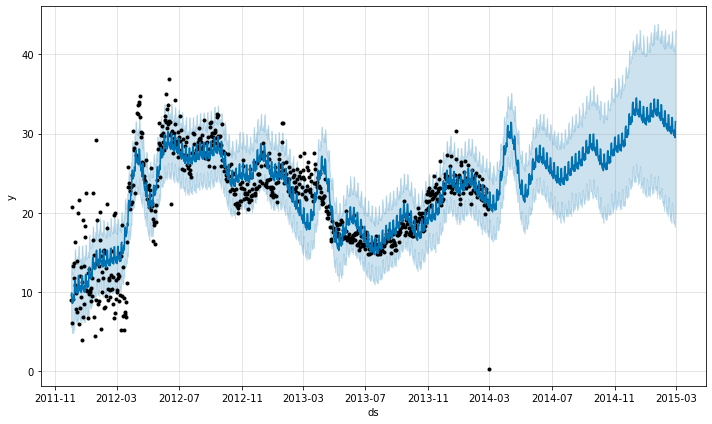

In [77]:
model.plot(forecast)
''

As you can see at some periods the predictions are poor and at some points they are pretty close. Let's have a closer look at the future.

(15.0, 30.0)

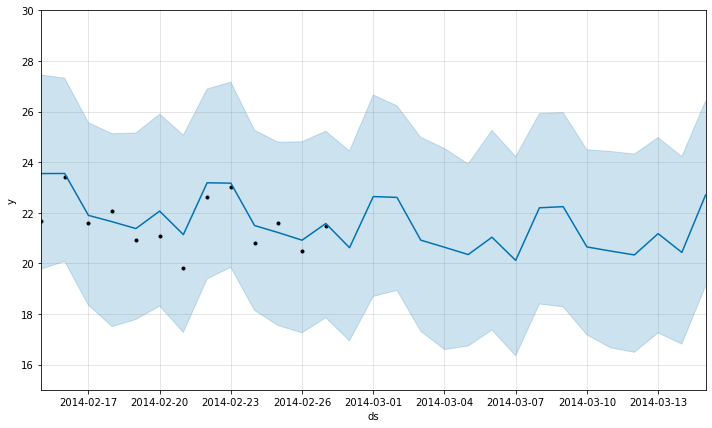

In [80]:
model.plot(forecast)
plt.xlim(pd.to_datetime(["2014-02-15", "2014-03-15"]))
plt.ylim([15, 30])

The model has found annual and weekly seasonalities. We can have closer look at these components using `.plot_components()`

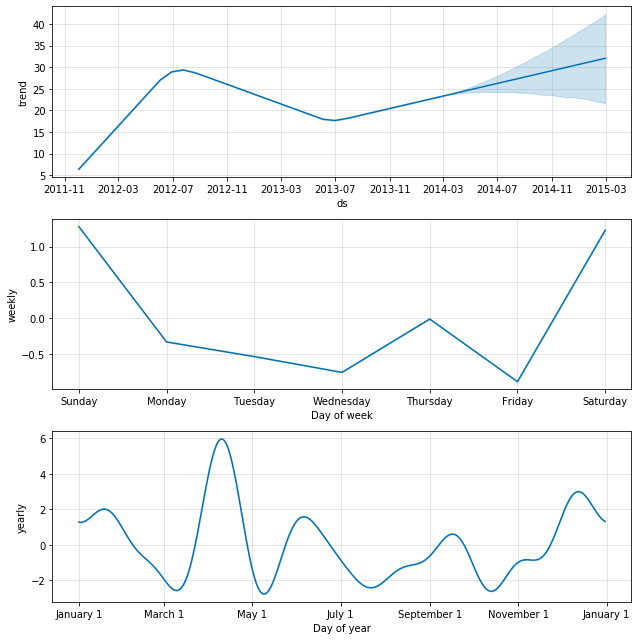

In [43]:
model.plot_components(forecast)

Now we can see which days of the week are associated with more energy consumption (it's not suprising to see Saturday and Sunday) and also how time of the year affects the energy consumption.

We created a model and forecasted the future. But we still don't know how good the model is. So like before we need a training and a validation set. We train a model on a training set, and then measure the accuracy of its prediction on validation set using metrics.<br>
One issue with this approach is that even when we get a value for predictions accuracy of a model, how do we know this value is reliable. Let's say we are comparing two models and mean absolute error for model A is 0.5 and for model B is 0.45. How do we know that B is better than A and it didn't just get lucky over this data set? One way to ensure which one is better is by comparing them over multiple sections of data sets. This approach is called cross validation. In Prophet, we start by training the model over the data from the eginning up to a certain point (cut-off point) and then predict for a few time steps (Horizon). Then we move cut-off point by a certain period and repeat the process. We can then calculate the metrics for each model over multiple sections of the data and have a better comparison at the end.

You need to specify the following inputs:
- initial: The initial length of training set.
- period: How much the cut-off point is moved after each training process.
- horizon: Length of forecasting period for which the metrics are calculcated.


In [53]:
from fbprophet.diagnostics import cross_validation

# Cross validation
cv = cross_validation(model, initial="365 days", period="90 days", horizon="30 days")

INFO:fbprophet:Making 5 forecasts with cutoffs between 2013-02-03 00:00:00 and 2014-01-29 00:00:00


In [54]:
cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-02-04,24.455175,21.198965,28.051403,22.283813,2013-02-03
1,2013-02-05,24.213246,20.731487,27.809553,22.148292,2013-02-03
2,2013-02-06,23.786783,20.215406,27.327385,23.066604,2013-02-03
3,2013-02-07,24.995388,21.748215,28.568968,22.582937,2013-02-03
4,2013-02-08,23.671178,20.272129,27.356807,23.103750,2013-02-03


The cross validation data frame shows the forecasted value (yhat) and its confidence range (yhat_upper and yhat_lower). We can use `performance_metrics` function to calculate the metrics.

In [55]:
from fbprophet.diagnostics import performance_metrics

perf = performance_metrics(cv)
perf

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,5.064539,2.250453,1.920771,0.096489,0.093233,0.933333
1,4 days,7.333416,2.708028,2.354503,0.119836,0.112818,0.866667
2,5 days,9.178053,3.029530,2.559893,0.131465,0.112818,0.800000
3,6 days,9.612460,3.100397,2.634022,0.136255,0.118749,0.800000
4,7 days,8.800147,2.966504,2.531245,0.131780,0.099211,0.733333
5,8 days,8.744677,2.957140,2.450529,0.125852,0.076222,0.733333
6,9 days,8.270390,2.875829,2.250561,0.113968,0.070252,0.733333
7,10 days,9.606802,3.099484,2.444901,0.122937,0.081162,0.733333
8,11 days,10.498306,3.240109,2.578387,0.131489,0.081162,0.666667
9,12 days,13.111660,3.621003,2.895136,0.148706,0.081162,0.600000


The dataframe above has multiple metrics for model's predictions.


<font color = red>__Note:__ In some versions of Prophet all the result is aggregated based on how far forecasted point is from cut-off point. If this is not the case, then you will see horizon column has repeated values (for instance multiple "10 days" entries) and you will need to use groupby.</font>

In [56]:
# uncomment and run if performance metrics are not aggregated based on horizon days

# perf = perf.groupby('horizon').mean()
# perf

Before running the next cell look at the performance data frame and find the first and last horizon days and enter it in the next cell as `start` and `end`.

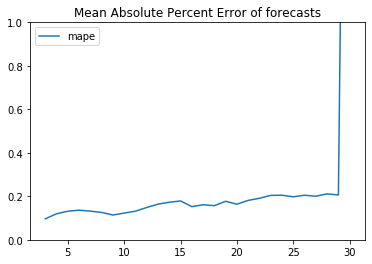

In [63]:
start = 3
end = 30
plt.plot(range(start, end + 1), perf[["mape"]])
plt.legend(["mape"])
plt.ylim((0, 1))
plt.title("Mean Absolute Percent Error of forecasts")

This plot shows the further we are from the cut-off point the larger the error is, which is what we expect. Now, let's compare this model with another one.<br>
Prophet has the ability to include the effect of holidays on the time series as well. Let's see whether adding public holidays to the model will make it any better.

In [64]:
holiday_df = pd.read_csv(
    "../../data/processed/smartmeter/uk_bank_holidays.csv",
    names=("ds", "holiday"),
    header=0,
)
holiday_df.head()

,ds,holiday
0,2012-12-26,Boxing Day
1,2012-12-25,Christmas Day
2,2012-08-27,Summer bank holiday
3,2012-05-06,Queen?s Diamond Jubilee (extra bank holiday)
4,2012-04-06,Spring bank holiday (substitute day)


In [69]:
model2 = Prophet(holidays=holiday_df)
model2.fit(df)

# Cross validation
cv2 = cross_validation(model2, initial="365 days", period="90 days", horizon="30 days")
perf2 = performance_metrics(cv2)
perf2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2013-02-03 00:00:00 and 2014-01-29 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,4.825613,2.196728,1.855974,0.093060,0.083582,0.866667
1,4 days,6.985142,2.642942,2.260226,0.114820,0.104536,0.866667
2,5 days,8.897809,2.982920,2.475059,0.126766,0.104536,0.800000
3,6 days,9.269442,3.044576,2.534092,0.130842,0.105975,0.800000
4,7 days,8.437055,2.904661,2.422944,0.126005,0.089405,0.733333
5,8 days,8.383857,2.895489,2.346004,0.120289,0.069030,0.733333
6,9 days,7.996049,2.827729,2.141393,0.108109,0.064719,0.733333
7,10 days,9.259325,3.042914,2.337638,0.117147,0.076955,0.733333
8,11 days,10.072079,3.173654,2.444442,0.124419,0.076955,0.666667
9,12 days,12.661286,3.558270,2.806835,0.144097,0.076955,0.600000


In [ ]:
# uncomment and run if performance metrics are not aggregated based on horizon days

# perf2 = perf2.groupby('horizon').mean()
# perf2

Now let's compare the models.

In [70]:
perf2

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,4.825613,2.196728,1.855974,0.093060,0.083582,0.866667
1,4 days,6.985142,2.642942,2.260226,0.114820,0.104536,0.866667
2,5 days,8.897809,2.982920,2.475059,0.126766,0.104536,0.800000
3,6 days,9.269442,3.044576,2.534092,0.130842,0.105975,0.800000
4,7 days,8.437055,2.904661,2.422944,0.126005,0.089405,0.733333
5,8 days,8.383857,2.895489,2.346004,0.120289,0.069030,0.733333
6,9 days,7.996049,2.827729,2.141393,0.108109,0.064719,0.733333
7,10 days,9.259325,3.042914,2.337638,0.117147,0.076955,0.733333
8,11 days,10.072079,3.173654,2.444442,0.124419,0.076955,0.666667
9,12 days,12.661286,3.558270,2.806835,0.144097,0.076955,0.600000


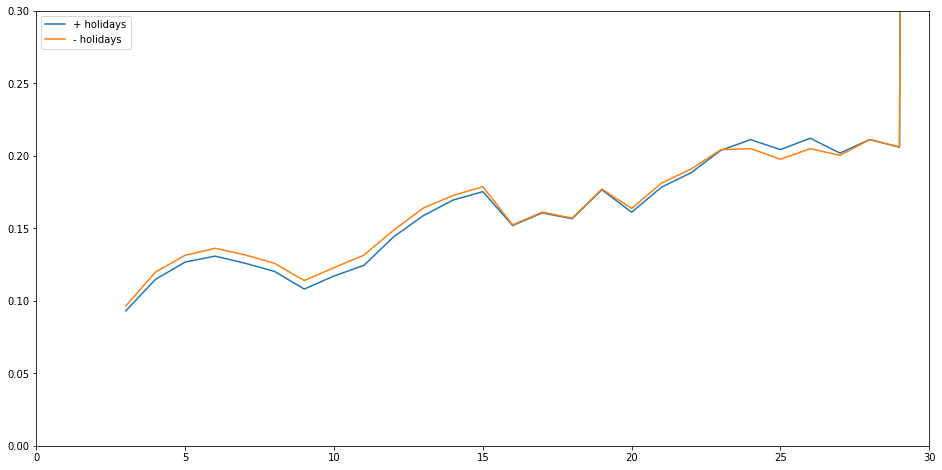

In [71]:
plt.figure(figsize=(16, 8))
plt.plot(range(start, end + 1), perf2["mape"], label="+ holidays")
plt.plot(range(start, end + 1), perf["mape"], label="- holidays")
plt.xlim(0, end)
plt.ylim(0, 0.3)
plt.legend()

It seems adding holidays slightly lowered the error for the first couple of weeks.

We can separately plot the models including the errors for all the horizons.

(0, 1)

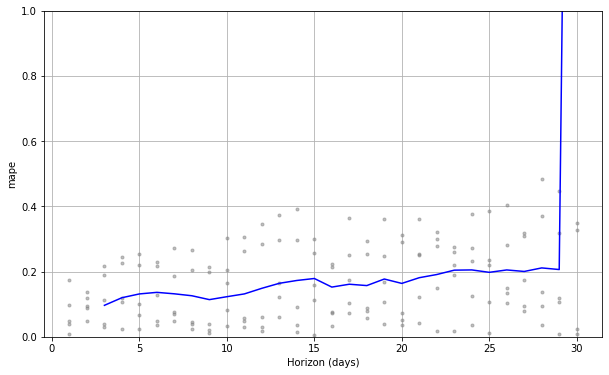

In [74]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(cv, metric="mape")
plt.ylim(0, 1)

One interesting feature of Prophet is that it can identify when the trend of the data is changing. We can add these change points to the plot as well.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


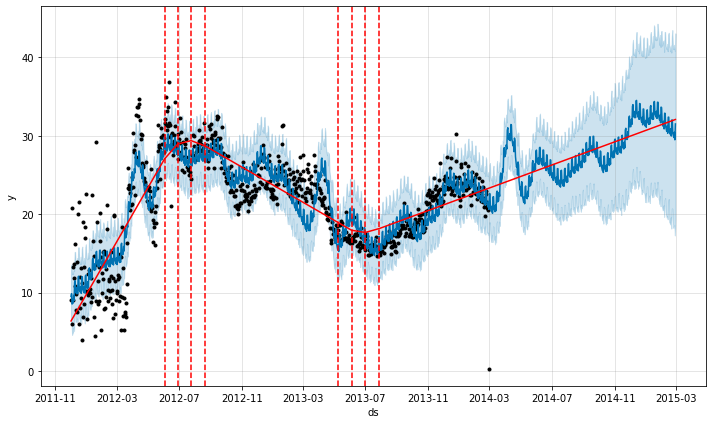

In [75]:
from fbprophet.plot import add_changepoints_to_plot

model = Prophet()
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

We can change the sensitivity of the model to the changes by setting `changepoint_prior_scale`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


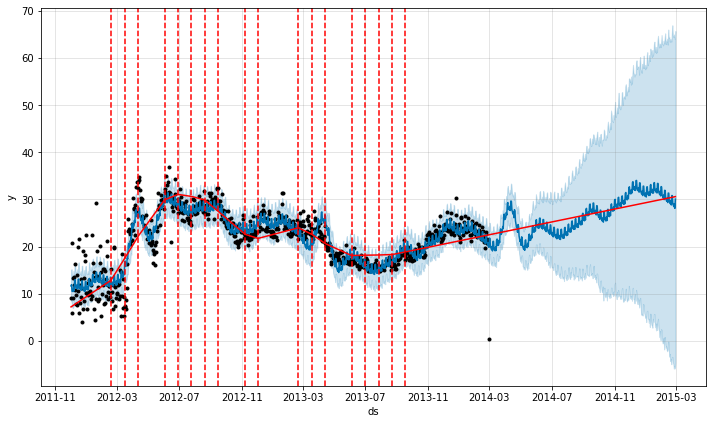

In [79]:
model = Prophet(changepoint_prior_scale=0.2)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

Prophet has many other parameters you can set to improve your model, including seasonality, growth type, etc. You can find more information about Facebook Prophet [here](https://facebook.github.io/prophet/docs/diagnostics.html).

# Exercise

Now that we have learned about various time series forecasting techniques, try to apply some of these techniques to another block of houses from electricity usage.

In [80]:
block1 = pd.read_csv("../../data/processed/smartmeter/block_1.csv")
block1.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000323,2012-03-06,0.5460,0.567700,0.908,20,0.235788,11.354,0.138
1,MAC000323,2012-03-07,0.2195,0.386062,1.475,48,0.348265,18.531,0.054
2,MAC000323,2012-03-08,0.1695,0.290937,1.086,48,0.262756,13.965,0.056
3,MAC000323,2012-03-09,0.2605,0.423812,1.587,48,0.402155,20.343,0.068
4,MAC000323,2012-03-10,0.2680,0.373813,1.222,48,0.308453,17.943,0.061


# Further Reading
- [Introduction to the Fundamentals of Time Series Data and Analysis](https://www.aptech.com/blog/introduction-to-the-fundamentals-of-time-series-data-and-analysis/)
- [The Complete Guide to Time Series Analysis and Forecasting](https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775)
- [How to Create an ARIMA Model for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/#:~:text=Autoregressive%20Integrated%20Moving%20Average%20Model,making%20skillful%20time%20series%20forecasts.)
- [SARIMAX: Introduction](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)
- [Generate Quick and Accurate Time Series Forecasts using Facebook’s Prophet](https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/#:~:text=Prophet%20is%20an%20open%20source,of%20custom%20seasonality%20and%20holidays!)
- [Facebook Prophet Documentation](https://facebook.github.io/prophet/docs/quick_start.html#python-api)
